In [30]:
import json
import re
from collections import defaultdict

# Function to find duplicate keys
def find_duplicate_keys(json_string):
    key_pattern = re.compile(r'"(.*?)"(?=\s*:)')
    keys = defaultdict(int)
    for match in key_pattern.finditer(json_string):
        keys[match.group(1)] += 1

    duplicates = {key: count for key, count in keys.items() if count > 1}
    return duplicates

# Load JSON file as string
with open('results_nlp.json', 'r') as file:
    json_string = file.read()

# Find and print duplicate keys
duplicates = find_duplicate_keys(json_string)
duplicates

{'vqa-v2': 209,
 'textvqa-ocr': 207,
 'textvqa-pure': 207,
 'gqa': 208,
 'refcoco': 202,
 'wsc273': 255,
 'winogrande': 255,
 'lambada_standard': 255,
 'arc_easy': 255,
 'arc_challenge': 255,
 'triviaqa': 189,
 'webqs': 196,
 'stage-final-llava-v15-pythia+160m-prompt': 2,
 'stage-final-llava-v15-pythia+1b': 2,
 'reproduction-align-pythia+410m': 2,
 'stage-final-llava-v15-pythia+160m-merging_per_epoch-16-epochs-1': 2,
 'reproduction-align-pythia+1p4b': 2,
 'reproduction-align-pythia+2p8b': 2,
 'reproduction-align-pythia+160m': 2,
 'stage-final-llava-v15-pythia+2p8b': 2,
 'reproduction-llava-v15+7b+stage-align+x7': 2,
 'reproduction-align-pythia+1b': 2,
 'stage-final-llava-v15-pythia+410m': 2,
 'stage-final-llava-v15-pythia+1p4b-sgm-old': 2,
 'stage-final-llava-v15-pythia+160m-ptune': 2,
 'cl-instruct-stage-0-pythia+410m': 2}

In [1]:
import os
import json
import numpy as np

# Define the datasets of interest
datasets = [
    'vqa-v2', 'textvqa-ocr', 'textvqa-pure', 'gqa', 'refcoco',
    'wsc273', 'winogrande', 'lambada_standard', 'arc_easy', 'arc_challenge',
    'triviaqa', 'webqs'
]

nl_datasets = [
    'wsc273', 'winogrande', 'lambada_standard', 'arc_easy', 'arc_challenge',
    'triviaqa', 'webqs'
]

# Define the result dictionary
result = {}

# Path to the JSON results file
results_file = 'results_nlp.json'

# Read the JSON results file
if os.path.isfile(results_file):
    with open(results_file, 'r') as f:
        result = json.load(f)
else:
    print(f"Error: File {results_file} not found.")

# Mapping from different methods to model names
model_mappings = {
    'soft': 'stage-final-llava-v15-pythia+160m-soft',
    'lora': 'stage-final-llava-v15-pythia+160m-lora',
    'sgm': 'stage-final-llava-v15-pythia+160m-sgm',
    'original': 'stage-final-llava-v15-pythia+160m',
    'vicuna': 'reproduction-align-pythia+160m',
    'olf': 'stage-final-llava-v15-pythia+160m-olf',
    'softolf': 'stage-final-llava-v15-pythia+160m-softolf',
    'sgmolf': 'stage-final-llava-v15-pythia+160m-sgmolf',
    'ia3': 'stage-final-llava-v15-pythia+160m-ia3',
    'lora-quarterfullrank': 'stage-final-llava-v15-pythia+160m-lora-use_rslora-rank_by_factor_4',
    'lora-quarterfullrank-higheralpha': 'stage-final-llava-v15-pythia+160m-lora-use_rslora-rank_by_factor_4-higheralpha-16',
    'lora-halffullrank-higheralpha': 'stage-final-llava-v15-pythia+160m-lora-use_rslora-rank_by_factor_2-higheralpha-32',
    'lora-halffullrank': 'stage-final-llava-v15-pythia+160m-lora-rank_by_factor_2',
    'lora-halffullrank-rslora': 'stage-final-llava-v15-pythia+160m-lora-use_rslora-rank_by_factor_2',
    'lora-halffullrank-rslora-kqv': 'stage-final-llava-v15-pythia+160m-lora-use_rslora-higher_rank-target_modules_kqv',
    'soft-0.001': 'stage-final-llava-v15-pythia+160m-soft-0.001',
    'soft-0.1': 'stage-final-llava-v15-pythia+160m-soft-0.1',
}

# Label name mappings for the main methods and variants of LoRA
name_mapping = {
    'soft': 'Soft Targets',
    'softolf': 'Soft Targets + OLF',
    'sgmolf': 'SGM + OLF',
    'sgm': 'SGM',
    'lora': 'LoRA',
    'ia3': 'IA3',
    'original': 'Original LLaVA',
    'vicuna': 'Language Only LLM',
    'olf': 'Output Layer Freezing (OLF)',
    'lora-old': 'LoRA (Rank 16, Alpha 8)',
    'lora-quarterfullrank': 'LoRA (1/4 Full Rank)',
    'lora-quarterfullrank-higheralpha': 'LoRA (1/4 Full Rank, Higher Alpha)',
    'lora-halffullrank-higheralpha': 'LoRA (1/2 Full Rank, Higher Alpha)',
    'lora-halffullrank': 'LoRA (1/2 Full Rank)',
    'lora-halffullrank-rslora': 'LoRA (1/2 Full Rank, RSLoRA)',
    'lora-halffullrank-rslora-kqv': 'LoRA (1/2 Full Rank, RSLoRA, KQV Target)',
    'soft-0.001': 'Soft Targets 0.001',
    'soft-0.1': 'Soft Targets 0.1'
}

# Initialize model mappings
model_results = {model: [] for model in model_mappings.keys()}

# Populate the mappings based on the given mappings
for method, model_name in model_mappings.items():
    if model_name in result:
        metrics = result[model_name]
        accuracies = list(metrics.values())
        avg_accuracy = np.nanmean(accuracies)
        model_results[method].append((model_name, avg_accuracy))
    else:
        print(f"Warning: Model '{model_name}' not found in results")

# Identify the highest accuracy model for each mapping
highest_accuracy_models = {}
for method, mappings in model_results.items():
    if mappings:
        highest_accuracy_models[method] = max(mappings, key=lambda x: x[1])

# Save the highest accuracy models to a file
output_file = 'highest_accuracy_models.json'
with open(output_file, 'w') as f:
    json.dump(highest_accuracy_models, f, indent=2)

# Prepare data for radar chart
methods = [name_mapping[model] for model in model_mappings.keys() if model in highest_accuracy_models]
results_dict = {}

for model in model_mappings.keys():
    if model in highest_accuracy_models:
        model_name, _ = highest_accuracy_models[model]
        metrics = result[model_name]
        accuracies = {dataset: metrics.get(dataset, np.nan) for dataset in datasets}
        results_dict[name_mapping[model]] = accuracies

# Output the results dictionary
print(json.dumps(results_dict, indent=2))

# Calculate delta values
original_llava_acc = results_dict["Original LLaVA"]
language_only_llm_acc = results_dict.get("Language Only LLM", {})

table_data = []

for model, accuracies in results_dict.items():
    if model in ["Original LLaVA", "Language Only LLM"]:
        continue

    missing_datasets = [dataset for dataset in nl_datasets if dataset not in accuracies or np.isnan(accuracies[dataset])]
    if missing_datasets:
        print(f"Warning: Model '{model}' is missing datasets: {missing_datasets}")
        continue

    avg_acc_vl = np.nanmean([accuracies[dataset] for dataset in ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa"]])
    nl_deltas = [
        ( ((language_only_llm_acc.get(dataset, np.nan) - accuracies[dataset]) / language_only_llm_acc.get(dataset, np.nan)))
        for dataset in nl_datasets
    ]
    delta_nl = np.nanmean(nl_deltas)
    print(f"{model}: {nl_deltas}")
    print(f"{model}: {delta_nl}")
    table_data.append((model, accuracies, avg_acc_vl, delta_nl))

# Sort the data by Avg. VL Accuracy and highest NL Delta
table_data = sorted(table_data, key=lambda x: (x[2], -x[3]), reverse=True)

# Separate the data into two groups
lora_variants = [
    'LoRA (1/4 Full Rank)', 'LoRA (1/4 Full Rank, Higher Alpha)', 
    'LoRA (1/2 Full Rank)', 'LoRA (1/2 Full Rank, Higher Alpha)', 
    'LoRA (1/2 Full Rank, RSLoRA)', 'LoRA (1/2 Full Rank, RSLoRA, KQV Target)'
]

lora_table_data = [item for item in table_data if item[0] in lora_variants]
other_table_data = [item for item in table_data if item[0] not in lora_variants]

# Function to format values or return "-"
def format_value(value):
    return "{:.4f}".format(value * 100) if not np.isnan(value) else "-"

# Generate LaTeX table for LoRA variants
latex_code_lora = """
\\begin{table*}[h]
  \\caption{\\textbf{LLaVA Model Performance:} LoRA Variants}
  \\label{tab:lora_variants_acc}
  \\centering
  \\resizebox{\\linewidth}{!}{
    \\begin{tabular}{l|cccc|c|c}
     \\toprule
     \\textbf{Model} & \\multicolumn{4}{c|}{\\textbf{Vision-Language (VL)}} & \\textbf{VL Avg.} & \\textbf{NL $\\Delta \\downarrow$} \\\\
     & \\textbf{VQAv2} & \\textbf{TextVQA OCR} & \\textbf{TextVQA Pure} & \\textbf{GQA} & Acc $\\uparrow$ & \\\\
     \\midrule
"""

original_llava_avg_delta_nl = np.nanmean([
    (((language_only_llm_acc.get(dataset, np.nan) - original_llava_acc.get(dataset, np.nan)) / language_only_llm_acc.get(dataset, np.nan)))
    for dataset in nl_datasets
])

latex_code_lora += "Original LLaVA & {vqa_v2} & {textvqa_ocr} & {textvqa_pure} & {gqa} & {avg_acc_vl} & {delta_nl} \\\\\n".format(
    vqa_v2=format_value(original_llava_acc["vqa-v2"]),
    textvqa_ocr=format_value(original_llava_acc["textvqa-ocr"]),
    textvqa_pure=format_value(original_llava_acc["textvqa-pure"]),
    gqa=format_value(original_llava_acc["gqa"]),
    avg_acc_vl=format_value(np.nanmean([original_llava_acc["vqa-v2"], original_llava_acc["textvqa-ocr"], original_llava_acc["textvqa-pure"], original_llava_acc["gqa"]])),
    delta_nl=format_value(original_llava_avg_delta_nl)
)

latex_code_lora += "Language Only LLM & {vqa_v2} & {textvqa_ocr} & {textvqa_pure} & {gqa} & {avg_acc_vl} & - \\\\\n".format(
    vqa_v2=format_value(language_only_llm_acc.get("vqa-v2", np.nan)),
    textvqa_ocr=format_value(language_only_llm_acc.get("textvqa-ocr", np.nan)),
    textvqa_pure=format_value(language_only_llm_acc.get("textvqa-pure", np.nan)),
    gqa=format_value(language_only_llm_acc.get("gqa", np.nan)),
    avg_acc_vl=format_value(np.nanmean([language_only_llm_acc.get("vqa-v2", 0), language_only_llm_acc.get("textvqa-ocr", 0), language_only_llm_acc.get("textvqa-pure", 0), language_only_llm_acc.get("gqa", 0)]))
)

latex_code_lora += "\\midrule\n"

for model, accuracies, avg_acc_vl, delta_nl in lora_table_data:
    latex_code_lora += "{model} & {vqa_v2} & {textvqa_ocr} & {textvqa_pure} & {gqa} & {acc_vl} & {delta_nl} \\\\\n".format(
        model=model,
        vqa_v2=format_value(accuracies["vqa-v2"]),
        textvqa_ocr=format_value(accuracies["textvqa-ocr"]),
        textvqa_pure=format_value(accuracies["textvqa-pure"]),
        gqa=format_value(accuracies["gqa"]),
        acc_vl=format_value(avg_acc_vl),
        delta_nl=format_value(delta_nl)
    )

latex_code_lora += """
     \\bottomrule
    \\end{tabular}
  }
\\end{table*}
"""

# Generate LaTeX table for other methods
latex_code_other = """
\\begin{table*}[h]
  \\caption{\\textbf{LLaVA Model Performance:} Other Methods}
  \\label{tab:other_methods_acc}
  \\centering
  \\resizebox{\\linewidth}{!}{
    \\begin{tabular}{l|cccc|c|c}
     \\toprule
     \\textbf{Model} & \\multicolumn{4}{c|}{\\textbf{Vision-Language (VL)}} & \\textbf{VL Avg.} & \\textbf{NL $\\Delta \\downarrow$} \\\\
     & \\textbf{VQAv2} & \\textbf{TextVQA OCR} & \\textbf{TextVQA Pure} & \\textbf{GQA} & Acc $\\uparrow$ & \\\\
     \\midrule
"""

latex_code_other += "Original LLaVA & {vqa_v2} & {textvqa_ocr} & {textvqa_pure} & {gqa} & {avg_acc_vl} & {delta_nl} \\\\\n".format(
    vqa_v2=format_value(original_llava_acc["vqa-v2"]),
    textvqa_ocr=format_value(original_llava_acc["textvqa-ocr"]),
    textvqa_pure=format_value(original_llava_acc["textvqa-pure"]),
    gqa=format_value(original_llava_acc["gqa"]),
    avg_acc_vl=format_value(np.nanmean([original_llava_acc["vqa-v2"], original_llava_acc["textvqa-ocr"], original_llava_acc["textvqa-pure"], original_llava_acc["gqa"]])),
    delta_nl=format_value(original_llava_avg_delta_nl)
)

latex_code_other += "Language Only LLM & {vqa_v2} & {textvqa_ocr} & {textvqa_pure} & {gqa} & {avg_acc_vl} & - \\\\\n".format(
    vqa_v2=format_value(language_only_llm_acc.get("vqa-v2", np.nan)),
    textvqa_ocr=format_value(language_only_llm_acc.get("textvqa-ocr", np.nan)),
    textvqa_pure=format_value(language_only_llm_acc.get("textvqa-pure", np.nan)),
    gqa=format_value(language_only_llm_acc.get("gqa", np.nan)),
    avg_acc_vl=format_value(np.nanmean([language_only_llm_acc.get("vqa-v2", 0), language_only_llm_acc.get("textvqa-ocr", 0), language_only_llm_acc.get("textvqa-pure", 0), language_only_llm_acc.get("gqa", 0)]))
)

latex_code_other += "\\midrule\n"

for model, accuracies, avg_acc_vl, delta_nl in other_table_data:
    latex_code_other += "{model} & {vqa_v2} & {textvqa_ocr} & {textvqa_pure} & {gqa} & {acc_vl} & {delta_nl} \\\\\n".format(
        model=model,
        vqa_v2=format_value(accuracies["vqa-v2"]),
        textvqa_ocr=format_value(accuracies["textvqa-ocr"]),
        textvqa_pure=format_value(accuracies["textvqa-pure"]),
        gqa=format_value(accuracies["gqa"]),
        acc_vl=format_value(avg_acc_vl),
        delta_nl=format_value(delta_nl)
    )

latex_code_other += """
     \\bottomrule
    \\end{tabular}
  }
\\end{table*}
"""

print(latex_code_lora)
print(latex_code_other)


{
  "Soft Targets": {
    "vqa-v2": 0.3267,
    "textvqa-ocr": 0.06923828124999999,
    "textvqa-pure": 0.061035156249999986,
    "gqa": 0.2539,
    "refcoco": 0.015625,
    "wsc273": 0.5128205128205128,
    "winogrande": 0.5082872928176796,
    "lambada_standard": 0.17019212109450804,
    "arc_easy": 0.39941077441077444,
    "arc_challenge": 0.2226962457337884,
    "triviaqa": 0.024743646901471242,
    "webqs": 0.00984251968503937
  },
  "LoRA": {
    "vqa-v2": 0.2897,
    "textvqa-ocr": 0.010156250000000002,
    "textvqa-pure": 0.017382812500000004,
    "gqa": 0.1797,
    "refcoco": 0.0009765625,
    "wsc273": 0.5897435897435898,
    "winogrande": 0.510655090765588,
    "lambada_standard": 0.22608189404230544,
    "arc_easy": 0.42592592592592593,
    "arc_challenge": 0.2030716723549488,
    "triviaqa": 0.008080695497102096,
    "webqs": 0.008366141732283465
  },
  "SGM": {
    "vqa-v2": 0.2839,
    "textvqa-ocr": 0.013671875,
    "textvqa-pure": 0.0271484375,
    "gqa": 0.1748,
    "

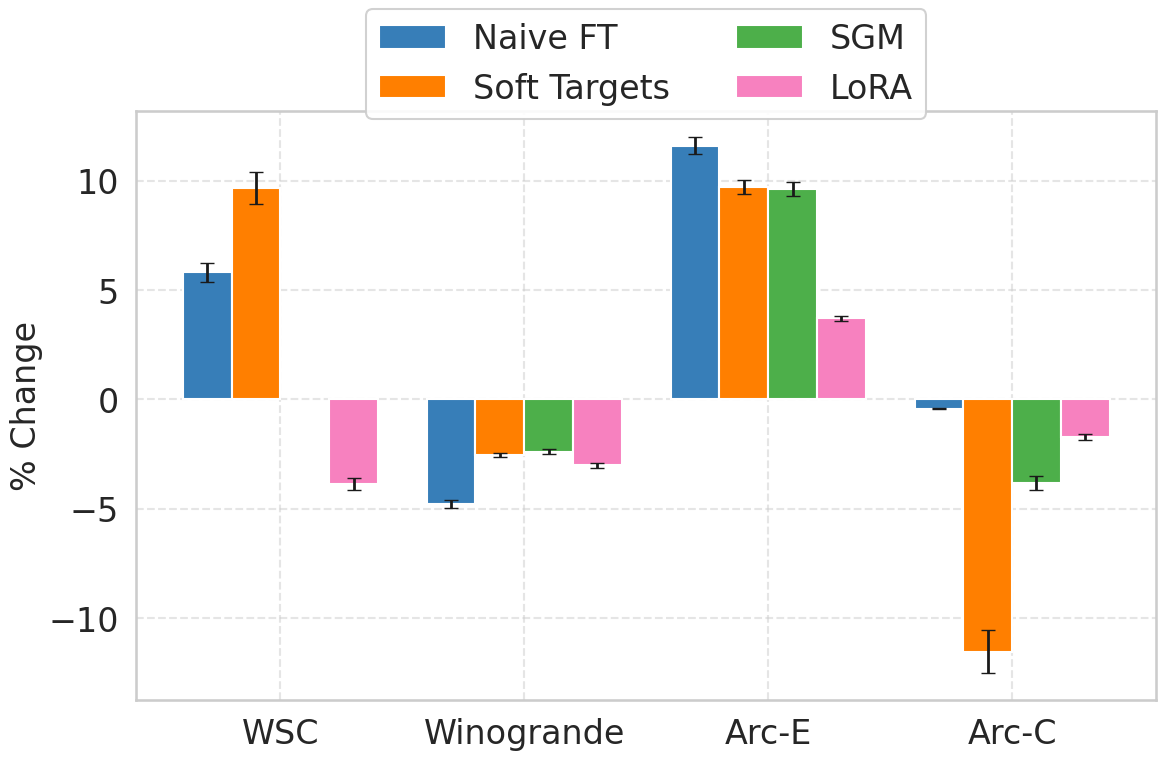

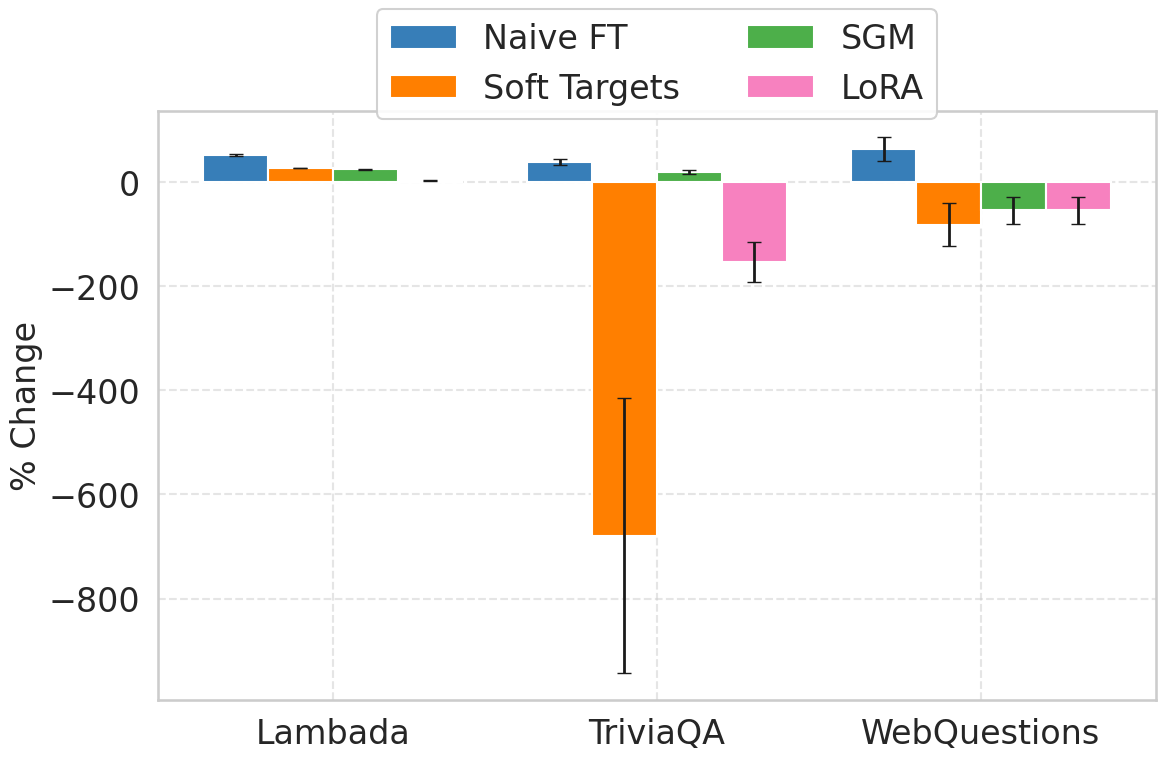

In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the datasets of interest
nlu_datasets = [
    'wsc273', 'winogrande', 'arc_easy', 'arc_challenge'
]

nlg_datasets = [
    'lambada_standard', 'triviaqa', 'webqs'
]

# Define the result dictionary
result = {}

# Path to the JSON results file
results_file = 'results_std.json'

# Read the JSON results file
if os.path.isfile(results_file):
    with open(results_file, 'r') as f:
        result = json.load(f)
else:
    print(f"Error: File {results_file} not found.")

# Mapping from different methods to model names
model_mappings = {
    'soft': 'stage-final-llava-v15-pythia+160m-soft',
    'sgm': 'stage-final-llava-v15-pythia+160m-sgm',
    'original': 'stage-final-llava-v15-pythia+160m',
    'vicuna': 'reproduction-align-pythia+160m',
    'lora': 'stage-final-llava-v15-pythia+160m-lora'
}

# Label name mappings for the main methods
name_mapping = {
    'soft': 'Soft Targets',
    'sgm': 'SGM',
    'original': 'Naive FT',
    'vicuna': 'Language Only LLM',
    'lora': 'LoRA'
}

# Initialize model mappings
model_results = {model: {} for model in model_mappings.keys()}
# Populate the mappings based on the given mappings
for method, model_name in model_mappings.items():
    if model_name in result:
        metrics = result[model_name]
        accuracies = {dataset: metrics.get(dataset, (np.nan, np.nan)) for dataset in nlu_datasets + nlg_datasets}
        model_results[method] = accuracies
    else:
        print(f"Warning: Model '{model_name}' not found in results")

# Calculate delta values
language_only_llm_acc = model_results["vicuna"]

def calculate_deltas(datasets):
    delta_values = {method: [] for method in model_results.keys() if method != 'vicuna'}
    delta_stderr = {method: [] for method in model_results.keys() if method != 'vicuna'}

    for method, accuracies in model_results.items():
        if method in ["vicuna"]:
            continue
        for dataset in datasets:
            acc_vlm, stderr_vlm = accuracies[dataset]
            acc_lang_only, stderr_lang_only = language_only_llm_acc[dataset]
            if acc_lang_only == 0 or np.isnan(acc_lang_only) or acc_lang_only == acc_vlm:
                delta_values[method].append(np.nan)
                delta_stderr[method].append(np.nan)
                print(f"Warning: Skipping dataset {dataset} for method {method}")
            else:
                # Calculate NL Delta (%)
                nl_delta = ((acc_lang_only - acc_vlm) / acc_lang_only) * 100
                
                # Calculate the error of the difference
                stderr_diff = np.sqrt(stderr_lang_only ** 2 + stderr_vlm ** 2)
                
                # Calculate the error of the ratio
                stderr_ratio = stderr_diff / acc_lang_only
                
                # Calculate the final NL Delta error
                nl_delta_error = stderr_ratio * abs(nl_delta)
                
                if nl_delta_error < 0 or np.isnan(nl_delta_error):
                    nl_delta_error = np.nan
                    print(f"Warning: Negative or NaN error for dataset {dataset} and method {method}")
                
                delta_values[method].append(nl_delta)
                delta_stderr[method].append(nl_delta_error)
    
    return delta_values, delta_stderr

# Calculate deltas for NLU and NLG datasets
nlu_delta_values, nlu_delta_stderr = calculate_deltas(nlu_datasets)
nlg_delta_values, nlg_delta_stderr = calculate_deltas(nlg_datasets)

# Plotting the bar charts
CB = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 24,
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
    'legend.fontsize': 24,
    'figure.figsize': [18, 10],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

plt.rcParams["figure.autolayout"] = True

methods_to_plot = ['original', 'soft', 'sgm', 'lora']
methods_labels = [name_mapping[method] for method in methods_to_plot]

# Plotting NLU Delta
x = np.arange(len(nlu_datasets))
width = 0.2  # Width of the bars

fig, ax = plt.subplots(figsize=[12, 8])

for i, method in enumerate(methods_to_plot):
    try:
        rects = ax.bar(x + i * width, nlu_delta_values[method], width, label=name_mapping[method], color=CB[i], yerr=nlu_delta_stderr[method], capsize=5)
    except Exception as e:
        print(f"Error for method {method}: {e}")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% Change', fontsize=24)
#ax.set_xlabel('NLU Datasets', fontsize=24)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(['WSC', 'Winogrande', 'Arc-E', 'Arc-C'])

plt.legend(fontsize=24, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, framealpha=0.9)

# Adjust layout to ensure everything fits
plt.tight_layout()
plt.savefig('nlu_delta_bar_chart.png', dpi=300)
plt.show()

# Plotting NLG Delta
x = np.arange(len(nlg_datasets))
width = 0.2  # Width of the bars

fig, ax = plt.subplots(figsize=[12, 8])

for i, method in enumerate(methods_to_plot):
    try:
        rects = ax.bar(x + i * width, nlg_delta_values[method], width, label=name_mapping[method], color=CB[i], yerr=nlg_delta_stderr[method], capsize=5)
    except Exception as e:
        print(f"Error for method {method}: {e}")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% Change', fontsize=24)
#ax.set_xlabel('NLG Datasets', fontsize=24)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(['Lambada', 'TriviaQA', 'WebQuestions'])

plt.legend(fontsize=24, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, framealpha=0.9)

# Adjust layout to ensure everything fits
plt.tight_layout()
plt.savefig('nlg_delta_bar_chart.png', dpi=300)
plt.show()

Ours, NLP Forgetting: {'stage-final-llava-v15-pythia+160m-soft': -104.03828824779978, 'stage-final-llava-v15-pythia+410m-soft': -60.19918744850445, 'stage-final-llava-v15-pythia+1b-soft': -30.647778768939826, 'stage-final-llava-v15-pythia+1p4b-soft': -41.755001762299756, 'stage-final-llava-v15-pythia+2p8b-soft': -27.26817834788273}
LLaVA, NLP Forgetting: {'stage-final-llava-v15-pythia+160m': 23.729565678876444, 'stage-final-llava-v15-pythia+410m': -38.3746723804614, 'stage-final-llava-v15-pythia+1b': -30.81407989718975, 'stage-final-llava-v15-pythia+1p4b': -29.7359558234371, 'stage-final-llava-v15-pythia+2p8b': -10.566050519597507}
Ours, NLP Performance: [4.408015265020224, 10.909386510108098, 17.259008550207295, 23.54691151627465, 21.756527186249887]
LLaVA, NLP Performance: [0.6725177652485205, 7.8349156991524245, 17.514941071657653, 20.988792873517777, 18.137551644496536]
Ours, NLP Forgetting: [-104.03828824779978, -60.19918744850445, -30.647778768939826, -41.755001762299756, -27.268

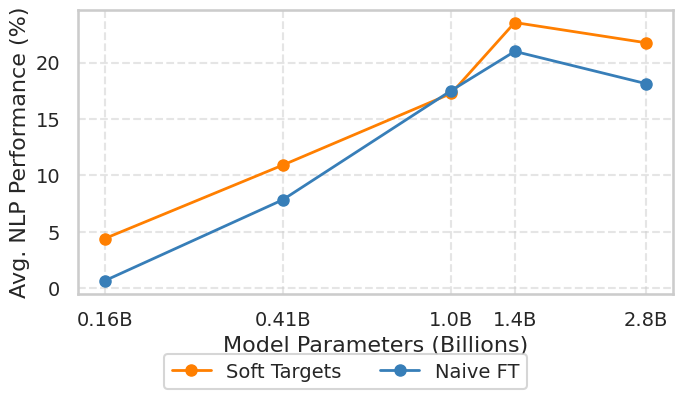

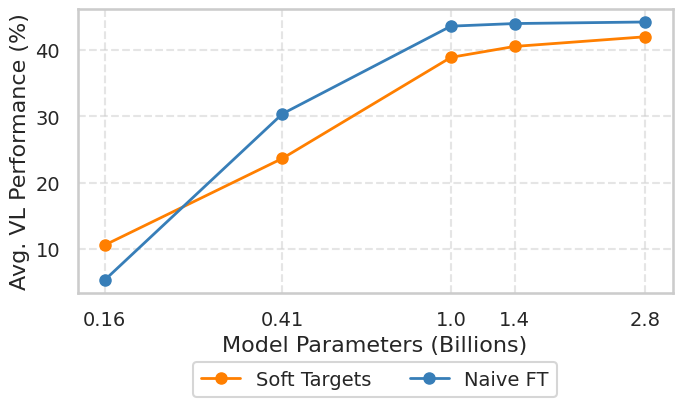

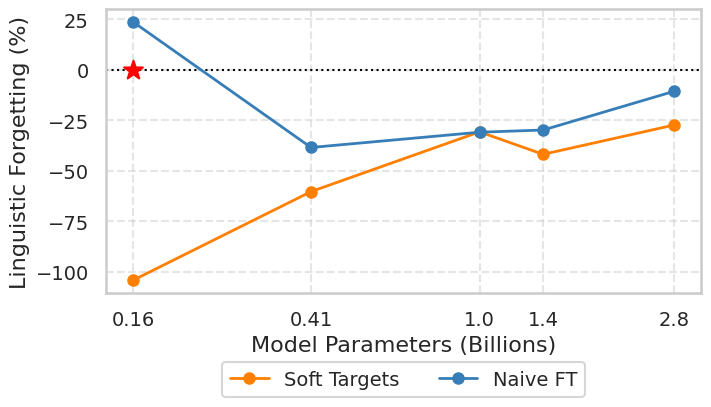

In [9]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hmean

sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.figsize': [7, 4],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# Define colorblind-friendly palette
CB_palette = ['#377EB8', '#FF7F00', '#4DAF4A',
              '#F781BF', '#A65628', '#984EA3',
              '#999999', '#E41A1C', '#DEDE00']
import json
# Load the JSON data from the file
with open('results_nlp.json', 'r') as f:
    results = json.load(f)


# Define the filtering criteria and datasets
nlu_datasets = ["wsc273", "winogrande", "arc_easy", "arc_challenge"]
nlg_datasets = ["lambada_standard", "triviaqa", "webqs"]
vl_datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa"]
all_nlp_datasets = nlu_datasets + nlg_datasets

# Define model scale to model name mapping
model_scale_to_name = {
    0.16: "160m",
    0.41: "410m",
    1.0: "1b",
    1.4: "1p4b",
    2.8: "2p8b"
}

# Define explicit mappings for LLaVA, Our methods, and Base LLM
llava_mapping = {
    0.16: "stage-final-llava-v15-pythia+160m",
    0.41: "stage-final-llava-v15-pythia+410m",
    1.0: "stage-final-llava-v15-pythia+1b",
    1.4: "stage-final-llava-v15-pythia+1p4b",
    2.8: "stage-final-llava-v15-pythia+2p8b"
}

our_mapping = {
    0.16: "stage-final-llava-v15-pythia+160m-soft",
    0.41: "stage-final-llava-v15-pythia+410m-soft",
    1.0: "stage-final-llava-v15-pythia+1b-soft",
    1.4: "stage-final-llava-v15-pythia+1p4b-soft",
    2.8: "stage-final-llava-v15-pythia+2p8b-soft"
}

base_llm_mapping = {
    0.16: "reproduction-align-pythia+160m",
    0.41: "reproduction-align-pythia+410m",
    1.0: "reproduction-align-pythia+1b",
    1.4: "reproduction-align-pythia+1p4b",
    2.8: "reproduction-align-pythia+2p8b"
}

# Filter and categorize models
filtered_results = {
    'our_method': {},
    'llava_method': {},
    'base_llm': {}
}

# Get filtered_results from the results dict based on the mappings
# For each value in the mapping, check if it exists in the results dict. If it does, add it to the filtered_results dict.
for _, value in llava_mapping.items():
    if value in results:
        filtered_results['llava_method'][value] = results[value]
for _, value in our_mapping.items():
    if value in results:
        filtered_results['our_method'][value] = results[value]
for _, value in base_llm_mapping.items():
    if value in results:
        filtered_results['base_llm'][value] = results[value]

# Calculate average performances and forgetting
def calculate_performance(metrics, datasets):
    performances = {}
    for model, data in metrics.items():
        scores = [data.get(dataset, np.nan) * 100 for dataset in datasets]
        valid_scores = [score for score in scores if not np.isnan(score)]
        if valid_scores:
            performances[model] = hmean(valid_scores)
        else:
            performances[model] = np.nan
    return performances

def calculate_nlp_delta(metrics, base_metrics, datasets):
    nlp_delta = {}

    for model in metrics:
        deltas = []
        for dataset in datasets:
            if '+160m' in model:
                base_score = base_metrics[base_llm_mapping[0.16]].get(dataset, np.nan) if base_llm_mapping[0.16] in base_metrics else np.nan
            elif '+410m' in model:
                base_score = base_metrics[base_llm_mapping[0.41]].get(dataset, np.nan) if base_llm_mapping[0.41] in base_metrics else np.nan
            elif '+1b' in model:
                base_score = base_metrics[base_llm_mapping[1.0]].get(dataset, np.nan) if base_llm_mapping[1.0] in base_metrics else np.nan
            elif '+1p4b' in model:
                base_score = base_metrics[base_llm_mapping[1.4]].get(dataset, np.nan) if base_llm_mapping[1.4] in base_metrics else np.nan
            elif '+2p8b' in model:
                base_score = base_metrics[base_llm_mapping[2.8]].get(dataset, np.nan) if base_llm_mapping[2.8] in base_metrics else np.nan
            model_score = metrics[model].get(dataset, np.nan)
            if not np.isnan(base_score) and not np.isnan(model_score) and base_score != 0:
                delta = ((base_score - model_score) / base_score) * 100
                deltas.append(delta)
        if deltas:
            nlp_delta[model] = np.nanmean(deltas)
        else:
            nlp_delta[model] = np.nan
    return nlp_delta

# Calculate NLP performance separately
nlp_performance_our = calculate_performance(filtered_results['our_method'], all_nlp_datasets)
nlp_performance_llava = calculate_performance(filtered_results['llava_method'], all_nlp_datasets)

# Calculate NLP delta (forgetting) for our method and LLaVA method
nlp_forgetting_llava = calculate_nlp_delta(filtered_results['llava_method'], filtered_results['base_llm'], all_nlp_datasets)
nlp_forgetting_our = calculate_nlp_delta(filtered_results['our_method'], filtered_results['base_llm'], all_nlp_datasets)

print(f"Ours, NLP Forgetting: {nlp_forgetting_our}")
print(f"LLaVA, NLP Forgetting: {nlp_forgetting_llava}")
# Combine all results for plotting
model_scales = [0.16, 0.41, 1.0, 1.4, 2.8]  # Example scales in billions

def get_performance(metric_dict, mapping, scale):
    model_name = mapping[scale]
    return metric_dict.get(model_name, np.nan)

# NLP performance for our method and LLaVA
our_nlp_performance = [get_performance(nlp_performance_our, our_mapping, scale) for scale in model_scales]
llava_nlp_performance = [get_performance(nlp_performance_llava, llava_mapping, scale) for scale in model_scales]

# NLP forgetting performance
our_nlp_forgetting = [get_performance(nlp_forgetting_our, our_mapping, scale) for scale in model_scales]
llava_nlp_forgetting = [get_performance(nlp_forgetting_llava, llava_mapping, scale) for scale in model_scales]

print(f"Ours, NLP Performance: {our_nlp_performance}")
print(f"LLaVA, NLP Performance: {llava_nlp_performance}")
print(f"Ours, NLP Forgetting: {our_nlp_forgetting}")
print(f"LLaVA, NLP Forgetting: {llava_nlp_forgetting}")

BOTTOM_PADDING = 0.265  # Adjust the bottom padding as needed
TOP_PADDING = 0.975  # Adjust the top padding as needed
RIGHT_PADDING = 0.965  # Adjust the right padding as needed
LEFT_PADDING = 0.115  # Adjust the left padding as needed

# Plot NLP performance
plt.figure()
plt.xscale('log')
line1, = plt.plot(model_scales, our_nlp_performance, color=CB_palette[1], marker='o', linestyle='-')
line2, = plt.plot(model_scales, llava_nlp_performance, color=CB_palette[0], marker='o', linestyle='-')

plt.xticks(model_scales, ['0.16B', '0.41B', '1.0B', '1.4B', '2.8B'])
plt.xlabel('Model Parameters (Billions)')
plt.ylabel('Avg. NLP Performance (%)')

plt.legend(handles=[line1, line2], labels=['Soft Targets', 'Naive FT'], loc='upper center', bbox_to_anchor=(0.45, -0.18), ncol=2)
plt.grid(True)
plt.tight_layout()
plt.subplots_adjust(bottom=BOTTOM_PADDING, top=TOP_PADDING, right=RIGHT_PADDING, left=LEFT_PADDING)
plt.savefig('nlp_performance.png', dpi=300)

# Plot Avg. VL Performance (Our Method and LLaVA Method)
our_vl_performance = calculate_performance(filtered_results['our_method'], vl_datasets)
llava_vl_performance = calculate_performance(filtered_results['llava_method'], vl_datasets)

plt.figure()
plt.xscale('log')
plt.plot(model_scales, [get_performance(our_vl_performance, our_mapping, scale) for scale in model_scales], label='Soft Targets', color=CB_palette[1], marker='o')
plt.plot(model_scales, [get_performance(llava_vl_performance, llava_mapping, scale) for scale in model_scales], label='Naive FT', color=CB_palette[0], linestyle='-', marker='o')
plt.xticks(model_scales, ['0.16', '0.41', '1.0', '1.4', '2.8'])
plt.xlabel('Model Parameters (Billions)')
plt.ylabel('Avg. VL Performance (%)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.21), ncol=2)
plt.grid(True)
plt.tight_layout()
plt.subplots_adjust(bottom=BOTTOM_PADDING, top=TOP_PADDING, right=RIGHT_PADDING, left=LEFT_PADDING)
plt.savefig('vl_performance.png', dpi=300)

# Plot NLP Forgetting
plt.figure()
plt.xscale('log')
line1, = plt.plot(model_scales, our_nlp_forgetting, color=CB_palette[1], marker='o', linestyle='-')
line2, = plt.plot(model_scales, llava_nlp_forgetting, color=CB_palette[0], marker='o', linestyle='-')

# Highlight the 0 horizontal line
plt.axhline(0, color='black', linestyle=':', linewidth=1.5, zorder=1)
plt.scatter(0.16, 0, color='red', marker='*', s=200, zorder=5)

plt.xticks(model_scales, ['0.16', '0.41', '1.0', '1.4', '2.8'])
plt.xlabel('Model Parameters (Billions)')
plt.ylabel('Linguistic Forgetting (%)')

plt.legend(handles=[line1, line2], labels=['Soft Targets', 'Naive FT'], loc='upper center', bbox_to_anchor=(0.5, -0.21), ncol=2)
plt.grid(True)
plt.tight_layout()
plt.subplots_adjust(bottom=BOTTOM_PADDING, top=TOP_PADDING, right=RIGHT_PADDING, left=LEFT_PADDING)
plt.savefig('nlp_forgetting.png', dpi=300)


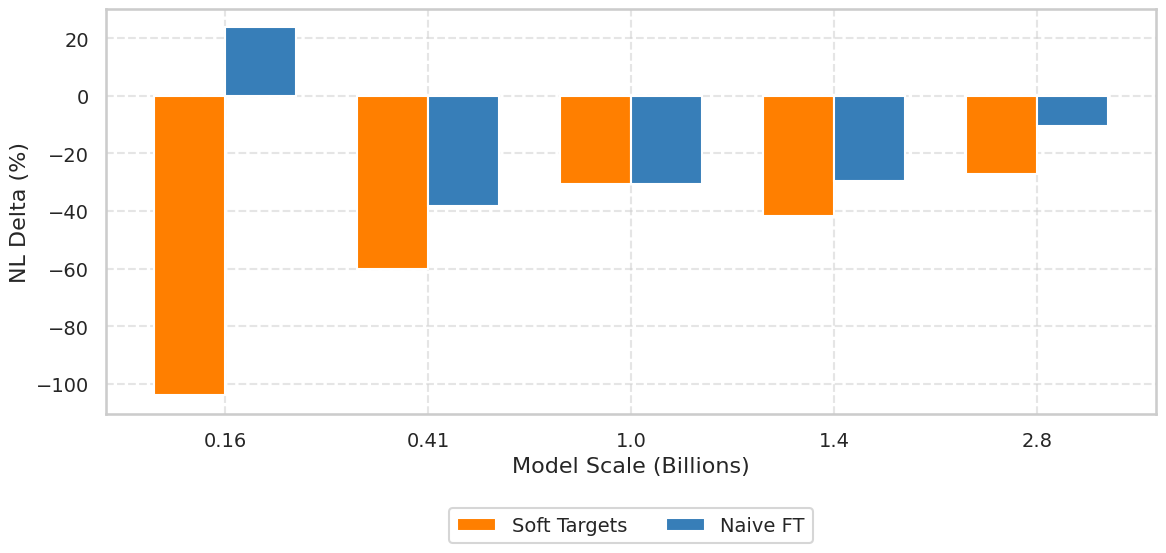

In [28]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Load the JSON data from the file
with open('results_nlp.json', 'r') as f:
    results = json.load(f)

# Define datasets
nlu_datasets = ["wsc273", "winogrande", "arc_easy", "arc_challenge"]
nlg_datasets = ["lambada_standard", "triviaqa", "webqs"]
all_nlp_datasets = nlu_datasets + nlg_datasets

# Define model scale to model name mapping
model_scale_to_name = {
    0.16: "160m",
    0.41: "410m",
    1.0: "1b",
    1.4: "1p4b",
    2.8: "2p8b"
}

# Define explicit mappings for LLaVA and our methods
llava_mapping = {
    0.16: "stage-final-llava-v15-pythia+160m",
    0.41: "stage-final-llava-v15-pythia+410m",
    1.0: "stage-final-llava-v15-pythia+1b",
    1.4: "stage-final-llava-v15-pythia+1p4b",
    2.8: "stage-final-llava-v15-pythia+2p8b"
}

our_mapping = {
    0.16: "stage-final-llava-v15-pythia+160m-soft",
    0.41: "stage-final-llava-v15-pythia+410m-soft",
    1.0: "stage-final-llava-v15-pythia+1b-soft",
    1.4: "stage-final-llava-v15-pythia+1p4b-soft",
    2.8: "stage-final-llava-v15-pythia+2p8b-soft"
}

base_llm_mapping = {
    0.16: "reproduction-align-pythia+160m",
    0.41: "reproduction-align-pythia+410m",
    1.0: "reproduction-align-pythia+1b",
    1.4: "reproduction-align-pythia+1p4b",
    2.8: "reproduction-align-pythia+2p8b"
}

# Filter and categorize models
filtered_results = {
    'our_method': {},
    'llava_method': {},
    'base_llm': {}
}

# Get filtered_results from the results dict based on the mappings
for _, value in llava_mapping.items():
    if value in results:
        filtered_results['llava_method'][value] = results[value]
for _, value in our_mapping.items():
    if value in results:
        filtered_results['our_method'][value] = results[value]
for _, value in base_llm_mapping.items():
    if value in results:
        filtered_results['base_llm'][value] = results[value]

# Calculate NL Delta
def calculate_nlp_delta(metrics, base_metrics, datasets):
    nlp_delta = defaultdict(dict)
    for model in metrics:
        for dataset in datasets:
            if '+160m' in model:
                base_score = base_metrics[base_llm_mapping[0.16]].get(dataset, np.nan) if base_llm_mapping[0.16] in base_metrics else np.nan
            elif '+410m' in model:
                base_score = base_metrics[base_llm_mapping[0.41]].get(dataset, np.nan) if base_llm_mapping[0.41] in base_metrics else np.nan
            elif '+1b' in model:
                base_score = base_metrics[base_llm_mapping[1.0]].get(dataset, np.nan) if base_llm_mapping[1.0] in base_metrics else np.nan
            elif '+1p4b' in model:
                base_score = base_metrics[base_llm_mapping[1.4]].get(dataset, np.nan) if base_llm_mapping[1.4] in base_metrics else np.nan
            elif '+2p8b' in model:
                base_score = base_metrics[base_llm_mapping[2.8]].get(dataset, np.nan) if base_llm_mapping[2.8] in base_metrics else np.nan
            model_score = metrics[model].get(dataset, np.nan)
            if not np.isnan(base_score) and not np.isnan(model_score) and base_score != 0:
                delta = ((base_score - model_score) / base_score) * 100
                nlp_delta[model][dataset] = delta
            else:
                nlp_delta[model][dataset] = np.nan
    return nlp_delta

# Calculate NLP delta for our method and LLaVA method
nlp_delta_llava = calculate_nlp_delta(filtered_results['llava_method'], filtered_results['base_llm'], all_nlp_datasets)
nlp_delta_our = calculate_nlp_delta(filtered_results['our_method'], filtered_results['base_llm'], all_nlp_datasets)

# Combine results for plotting
model_scales = [0.16, 0.41, 1.0, 1.4, 2.8]

def get_avg_delta(nlp_delta, mapping, scale):
    model_name = mapping[scale]
    deltas = list(nlp_delta[model_name].values())
    valid_deltas = [delta for delta in deltas if not np.isnan(delta)]
    return np.mean(valid_deltas) if valid_deltas else np.nan

# Average NLP delta for our method and LLaVA
our_nlp_delta = [get_avg_delta(nlp_delta_our, our_mapping, scale) for scale in model_scales]
llava_nlp_delta = [get_avg_delta(nlp_delta_llava, llava_mapping, scale) for scale in model_scales]

# Plotting
sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.figsize': [12, 6],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# Define colorblind-friendly palette
CB_palette = ['#377EB8', '#FF7F00', '#4DAF4A', '#F781BF', '#A65628', '#984EA3', '#999999', '#E41A1C', '#DEDE00']

plt.figure()
bar_width = 0.35
index = np.arange(len(model_scales))

bar1 = plt.bar(index, our_nlp_delta, bar_width, label='Soft Targets', color=CB_palette[1])
bar2 = plt.bar(index + bar_width, llava_nlp_delta, bar_width, label='Naive FT', color=CB_palette[0])

plt.xlabel('Model Scale (Billions)')
plt.ylabel('NL Delta (%)')
#plt.title('NL Delta (Percentage Change) for Different Model Scales')
plt.xticks(index + bar_width / 2, ['0.16', '0.41', '1.0', '1.4', '2.8'])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.21), ncol=2)

plt.tight_layout()
plt.savefig('nl_delta_bar_chart.png', dpi=300)
plt.show()

In [1]:
import os
os.chdir('..')

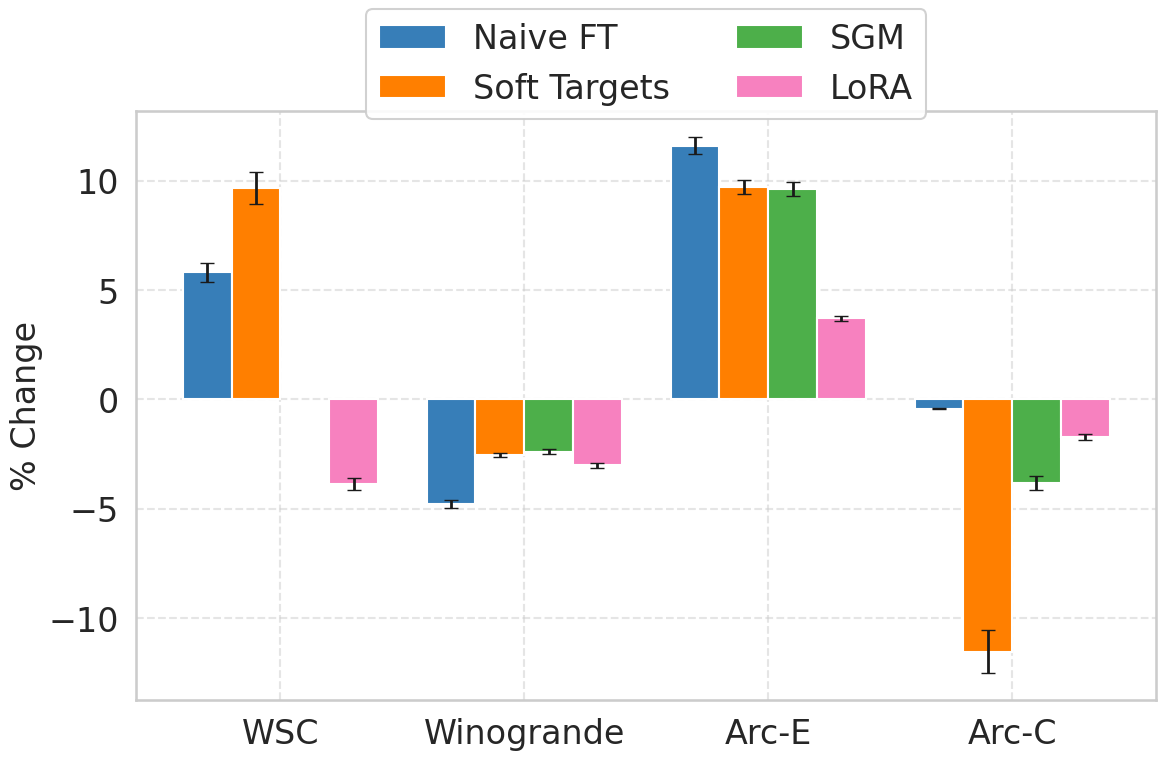

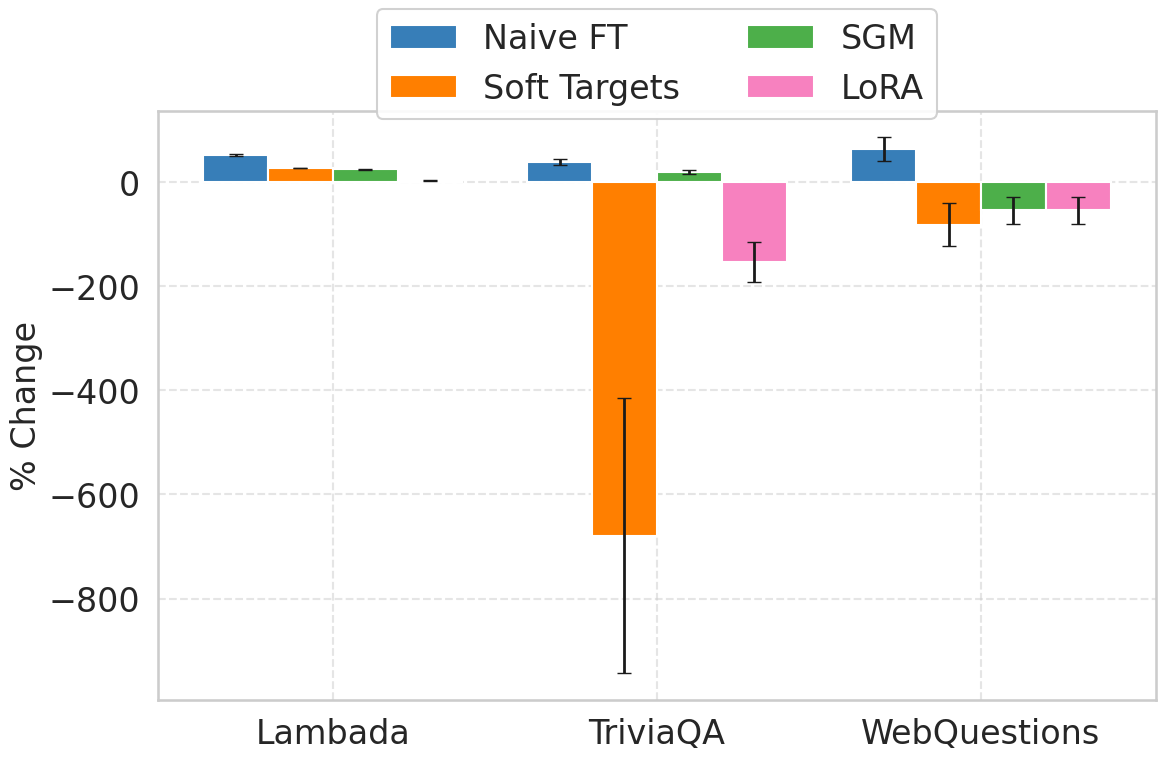

In [2]:


import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the datasets of interest
nlu_datasets = [
    'wsc273', 'winogrande', 'arc_easy', 'arc_challenge'
]

nlg_datasets = [
    'lambada_standard', 'triviaqa', 'webqs'
]

# Define the result dictionary
result = {}

# Path to the JSON results file
results_file = 'results_std.json'

# Read the JSON results file
if os.path.isfile(results_file):
    with open(results_file, 'r') as f:
        result = json.load(f)
else:
    print(f"Error: File {results_file} not found.")

# Mapping from different methods to model names
model_mappings = {
    'soft': 'stage-final-llava-v15-pythia+160m-soft',
    'sgm': 'stage-final-llava-v15-pythia+160m-sgm',
    'original': 'stage-final-llava-v15-pythia+160m',
    'vicuna': 'reproduction-align-pythia+160m',
    'lora': 'stage-final-llava-v15-pythia+160m-lora'
}

# Label name mappings for the main methods
name_mapping = {
    'soft': 'Soft Targets',
    'sgm': 'SGM',
    'original': 'Naive FT',
    'vicuna': 'Language Only LLM',
    'lora': 'LoRA'
}

# Initialize model mappings
model_results = {model: {} for model in model_mappings.keys()}
# Populate the mappings based on the given mappings
for method, model_name in model_mappings.items():
    if model_name in result:
        metrics = result[model_name]
        accuracies = {dataset: metrics.get(dataset, (np.nan, np.nan)) for dataset in nlu_datasets + nlg_datasets}
        model_results[method] = accuracies
    else:
        print(f"Warning: Model '{model_name}' not found in results")

# Calculate delta values
language_only_llm_acc = model_results["vicuna"]

def calculate_deltas(datasets):
    delta_values = {method: [] for method in model_results.keys() if method != 'vicuna'}
    delta_stderr = {method: [] for method in model_results.keys() if method != 'vicuna'}

    for method, accuracies in model_results.items():
        if method in ["vicuna"]:
            continue
        for dataset in datasets:
            acc_vlm, stderr_vlm = accuracies[dataset]
            acc_lang_only, stderr_lang_only = language_only_llm_acc[dataset]
            if acc_lang_only == 0 or np.isnan(acc_lang_only) or acc_lang_only == acc_vlm:
                delta_values[method].append(np.nan)
                delta_stderr[method].append(np.nan)
                print(f"Warning: Skipping dataset {dataset} for method {method}")
            else:
                # Calculate NL Delta (%)
                nl_delta = ((acc_lang_only - acc_vlm) / acc_lang_only) * 100
                
                # Calculate the error of the difference
                stderr_diff = np.sqrt(stderr_lang_only ** 2 + stderr_vlm ** 2)
                
                # Calculate the error of the ratio
                stderr_ratio = stderr_diff / acc_lang_only
                
                # Calculate the final NL Delta error
                nl_delta_error = stderr_ratio * abs(nl_delta)
                
                if nl_delta_error < 0 or np.isnan(nl_delta_error):
                    nl_delta_error = np.nan
                    print(f"Warning: Negative or NaN error for dataset {dataset} and method {method}")
                
                delta_values[method].append(nl_delta)
                delta_stderr[method].append(nl_delta_error)
    
    return delta_values, delta_stderr

# Calculate deltas for NLU and NLG datasets
nlu_delta_values, nlu_delta_stderr = calculate_deltas(nlu_datasets)
nlg_delta_values, nlg_delta_stderr = calculate_deltas(nlg_datasets)

# Plotting the bar charts
CB = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 24,
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
    'legend.fontsize': 24,
    'figure.figsize': [18, 10],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

plt.rcParams["figure.autolayout"] = True

methods_to_plot = ['original', 'soft', 'sgm', 'lora']
methods_labels = [name_mapping[method] for method in methods_to_plot]

# Plotting NLU Delta
x = np.arange(len(nlu_datasets))
width = 0.2  # Width of the bars

fig, ax = plt.subplots(figsize=[12, 8])

for i, method in enumerate(methods_to_plot):
    try:
        rects = ax.bar(x + i * width, nlu_delta_values[method], width, label=name_mapping[method], color=CB[i], yerr=nlu_delta_stderr[method], capsize=5)
    except Exception as e:
        print(f"Error for method {method}: {e}")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% Change', fontsize=24)
#ax.set_xlabel('NLU Datasets', fontsize=24)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(['WSC', 'Winogrande', 'Arc-E', 'Arc-C'])

plt.legend(fontsize=24, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, framealpha=0.9)

# Adjust layout to ensure everything fits
plt.tight_layout()
plt.savefig('nlu_delta_bar_chart.png', dpi=300)
plt.show()

# Plotting NLG Delta
x = np.arange(len(nlg_datasets))
width = 0.2  # Width of the bars

fig, ax = plt.subplots(figsize=[12, 8])

for i, method in enumerate(methods_to_plot):
    try:
        rects = ax.bar(x + i * width, nlg_delta_values[method], width, label=name_mapping[method], color=CB[i], yerr=nlg_delta_stderr[method], capsize=5)
    except Exception as e:
        print(f"Error for method {method}: {e}")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% Change', fontsize=24)
#ax.set_xlabel('NLG Datasets', fontsize=24)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(['Lambada', 'TriviaQA', 'WebQuestions'])

plt.legend(fontsize=24, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, framealpha=0.9)

# Adjust layout to ensure everything fits
plt.tight_layout()
plt.savefig('nlg_delta_bar_chart_updated.png', dpi=300)
plt.show()

In [7]:
# --- ADD *BELOW* THE EXISTING PLOTTING CODE ---------------------------------
# ---------------------------------------------------------------------------
# Build two tables for the **NLG** datasets only:
#   1. Raw accuracy ± stderr for every method **including** Language‑Only LLM
#   2. %‑change (Δ) w.r.t. Language‑Only LLM ➀

import pandas as pd

##############################################################################
# 1. Table of raw values (+/‑ stderr)
##############################################################################
raw_rows = []
for m in ['original', 'soft', 'sgm', 'lora', 'vicuna']:           # keep order
    accs = model_results[m]
    raw_rows.append([
        name_mapping.get(m, 'Language Only LLM'),                # label
        f"{accs['lambada_standard'][0]:.4f} ± {accs['lambada_standard'][1]:.4f}",
        f"{accs['triviaqa'][0]:.4f} ± {accs['triviaqa'][1]:.4f}",
        f"{accs['webqs'][0]:.4f} ± {accs['webqs'][1]:.4f}",
    ])

raw_df = pd.DataFrame(
    raw_rows,
    columns=['Method', 'Lambada (Acc)', 'TriviaQA (EM)', 'WebQuestions (EM)']
)

print("\n\n### Raw values (accuracy ± stderr)\n")
print(raw_df.to_markdown(index=False))


##############################################################################
# 2. Table of %‑change relative to language‑only baseline
##############################################################################
delta_rows = []
for m in ['original', 'soft', 'sgm', 'lora']:                     # exclude vicuna
    delta_rows.append([
        name_mapping[m],
        f"{nlg_delta_values[m][0]:.4f} ± {nlg_delta_stderr[m][0]:.4f}",
        f"{nlg_delta_values[m][1]:.4f} ± {nlg_delta_stderr[m][1]:.4f}",
        f"{nlg_delta_values[m][2]:.4f} ± {nlg_delta_stderr[m][2]:.4f}",
    ])

delta_df = pd.DataFrame(
    delta_rows,
    columns=['Method', 'Lambada (Δ %)', 'TriviaQA (Δ %)', 'WebQuestions (Δ %)']
)

print("\n\n### %‑change vs Language‑Only LLM\n")
print(delta_df.to_markdown(index=False))



### Raw values (accuracy ± stderr)

| Method            | Lambada (Acc)   | TriviaQA (EM)   | WebQuestions (EM)   |
|:------------------|:----------------|:----------------|:--------------------|
| Naive FT          | 0.1131 ± 0.0044 | 0.0020 ± 0.0003 | 0.0020 ± 0.0010     |
| Soft Targets      | 0.1702 ± 0.0052 | 0.0247 ± 0.0012 | 0.0098 ± 0.0022     |
| SGM               | 0.1770 ± 0.0053 | 0.0026 ± 0.0004 | 0.0084 ± 0.0020     |
| LoRA              | 0.2261 ± 0.0058 | 0.0081 ± 0.0007 | 0.0084 ± 0.0020     |
| Language Only LLM | 0.2335 ± 0.0059 | 0.0032 ± 0.0004 | 0.0054 ± 0.0016     |


### %‑change vs Language‑Only LLM

| Method       | Lambada (Δ %)    | TriviaQA (Δ %)       | WebQuestions (Δ %)   |
|:-------------|:-----------------|:---------------------|:---------------------|
| Naive FT     | 51.5378 ± 1.6254 | 38.5965 ± 6.4862     | 63.6364 ± 22.3608    |
| Soft Targets | 27.0989 ± 0.9151 | -678.9474 ± 263.6315 | -81.8182 ± 41.2517   |
| SGM          | 24.1895 ± 0.8225 | 1

In [6]:
### Raw values (accuracy ± stderr)

| Method            | WebQuestions (EM) | TriviaQA (EM) | Lambada (Acc %) |
|:------------------|:------------------|:--------------|:----------------|
|  *Language Only LLM (160M)* | 5.4 ± 1.6         | 3.2 ± 0.4     | 23.35 ± 0.59    |
| Naive FT          | 2.0 ± 1.0         | 2.0 ± 0.3     | 11.31 ± 0.44    |
| mSGM              | 8.4 ± 2.0         | 2.6 ± 0.4     | 17.70 ± 0.53    |
| LoRA              | 8.4 ± 2.0         | 8.1 ± 0.7     | 22.61 ± 0.58    |
| Soft Targets      | 9.8 ± 2.2         | 24.7 ± 1.2    | 17.02 ± 0.52    |


Lambada values are in Accuracy %, wherease TriviaQA and WebQuestions are evaluated using Exact Match (EM) values and reported in 1e-3.

### %‑change vs Language‑Only LLM

| Method       | WebQuestions Δ′ ↓ | TriviaQA Δ′ ↓   | Lambada Δ′ ↓   |
|:-------------|:------------------|:----------------|:---------------|
| Naive FT     | 0.636 ± 0.224     | 0.386 ± 0.065   | 0.515 ± 0.016  |
| mSGM          | -0.545 ± 0.262    | 0.193 ± 0.034   | 0.242 ± 0.008  |
| Soft Targets | -0.818 ± 0.413    | -6.789 ± 2.636  | 0.271 ± 0.009  |

In order to compare across the NLG benchmarks, we use a relative change metric (Δ') for all datasets.
 Δ' is calculated as [(baseline − method) / baseline], and derive error bars by propagating standard errors via √(se_baseline² + se_method²) / baseline EM | change|.

SyntaxError: invalid syntax (9234190.py, line 3)